## Objective


In [1]:
import neptune
from neptunecontrib.monitoring.metrics import expand_prediction, log_class_metrics, log_binary_classification_metrics, log_classification_report,log_confusion_matrix,log_prediction_distribution
from neptunecontrib.api import log_table
import os
from dotenv import load_dotenv

load_dotenv()
NEPTUNE_PROJECT= os.getenv('NEPTUNE_PROJECT')
NEPTUNE_API_TOKEN = os.getenv(('NEPTUNE_API_TOKEN'))
neptune.init(project_qualified_name= NEPTUNE_PROJECT,api_token=NEPTUNE_API_TOKEN) 
             

Project(codekcg23/Research-Experiments)

In [2]:
## libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
#from sklearn.metrics import accuracy_score, f1_score, precision_score,roc_curve,roc_auc_score,confusion_matrix,recall_score
from sklearn.pipeline import Pipeline
import re
import gensim
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# import helper function script
import sys
sys.path.insert(1,'G:\\Github\\Sinhala-Hate-Speech-Detection')
import utills

In [3]:
## datasets
# load datasets
path = '../Datasets/processed/preprocessed/'
df_A = pd.read_csv(path+'df_A.csv')    
df_B = pd.read_csv(path+'df_B.csv')    # fb dataset -kaggle 
df_A_B = pd.read_csv(path+'df_A_B.csv') 
## Remove NaN instances after preprocessed and save it again new folder
#print(df_A.iloc[610])
df_A.drop(index =[610,3070],inplace=True)

#print(df_B.iloc[14:20])

df_B.drop(index =[16,19],inplace=True)
# df_B had two roads including english words
nan_values = df_A_B[df_A_B['cleaned'].isna()]
print (nan_values)
df_A_B.drop(index =[610,3070,6484,6487],inplace=True)

      comment  label df cleaned
610        <>      0  A     NaN
3070      <3,      0  A     NaN
6484  Hkzz...      0  B     NaN
6487     ROX       0  B     NaN


In [5]:
df= df_A

In [73]:
df_A.label.value_counts().to_frame().T

,0,1
label,4454,2012


## Orginal Data

In [8]:
final_result =pd.DataFrame(columns=['Accuracy','F1-score','Recall','Precision','AUC'])
feature_name ="bow_char"
model_name ='LR'
df_name ='df_A'
X_train, X_test, Y_train, Y_test = train_test_split(
        df['cleaned'], df['label'], test_size=0.3, random_state=0, stratify=df['label'].values)
Y_train.value_counts().to_frame().T

,0,1
label,3118,1408


              precision    recall  f1-score   support

           0       0.87      0.91      0.89      1336
           1       0.79      0.69      0.74       604

    accuracy                           0.85      1940
   macro avg       0.83      0.80      0.81      1940
weighted avg       0.84      0.85      0.84      1940



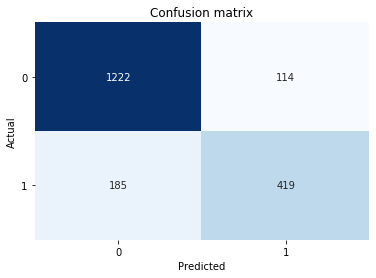

========= Eperiment -  baseline  =========


Info (NVML): NVML Shared Library Not Found. GPU usage metrics may not be reported. For more information, see https://docs-legacy.neptune.ai/logging-and-managing-experiment-results/logging-experiment-data.html#hardware-consumption 


https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-382


In [11]:
## Losgistic regression model
name="baseline"
tag ="imbalance"
X_train_bow,X_test_bow = utills.bow_char(X_train,X_test)
Y_pred_bow = utills.lr(X_train_bow, X_test_bow, Y_train)
accuracy, f1_score, recall, precision, auc = utills.result(Y_test,Y_pred_bow)
utills.log_result(Y_test,Y_pred_bow,name,df_name,feature_name,model_name,tag)
final_result.loc[name] = [accuracy, f1_score, recall, precision, auc]

## Class weights

In [12]:
def lr(X_train, X_test, Y_train):
    from sklearn.linear_model import LogisticRegression
    lr = LogisticRegression(class_weight='balanced')
    lr.fit(X_train, Y_train)
    Y_pred = lr.predict(X_test)
    return Y_pred

              precision    recall  f1-score   support

           0       0.88      0.89      0.88      1336
           1       0.75      0.74      0.74       604

    accuracy                           0.84      1940
   macro avg       0.81      0.81      0.81      1940
weighted avg       0.84      0.84      0.84      1940



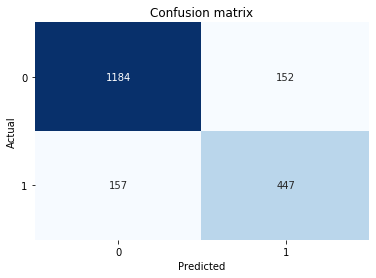

========= Eperiment -  class_weights  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-383


,0,1
label,3118,1408


In [13]:
## Losgistic regression model
name="class_weights"
tag ="imbalance"
X_train_weight,X_test_weight = utills.bow_char(X_train,X_test)
Y_pred_weight = lr(X_train_weight, X_test_weight, Y_train)
accuracy, f1_score, recall, precision, auc = utills.result(Y_test,Y_pred_weight)
utills.log_result(Y_test,Y_pred_weight,name,df_name,feature_name,model_name,tag)
final_result.loc[name] = [accuracy, f1_score, recall, precision, auc]
Y_train.value_counts().to_frame().T

## Oversampling

In [53]:
ros = RandomOverSampler(random_state=0) 
X_ros, Y_ros = ros.fit_resample(X_train.values.reshape(-1,1), Y_train)
Y_ros.value_counts().to_frame().T

,0,1
label,3118,3118


              precision    recall  f1-score   support

           0       0.88      0.89      0.89      1336
           1       0.75      0.73      0.74       604

    accuracy                           0.84      1940
   macro avg       0.82      0.81      0.81      1940
weighted avg       0.84      0.84      0.84      1940



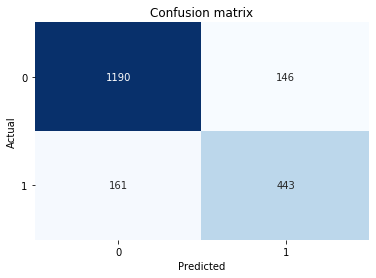

========= Eperiment -  oversampling  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-384


In [62]:
## Losgistic regression model
name="oversampling"
tag ="imbalance"
# y_train = upsampled.Class
# X_train = upsampled.drop('Class', axis=1)
X_ros,X_test_ros = utills.bow_char(X_ros.flatten(),X_test)
Y_pred_ros = utills.lr(X_ros, X_test_ros, Y_ros)
accuracy, f1_score, recall, precision, auc = utills.result(Y_test,Y_pred_ros)
utills.log_result(Y_test,Y_pred_ros,name,df_name,feature_name,model_name,tag)
final_result.loc[name] = [accuracy, f1_score, recall, precision, auc]

## Undersampling

In [69]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0) 
X_rus, Y_rus = rus.fit_resample(X_train.values.reshape(-1,1), Y_train)
Y_rus.value_counts().to_frame().T

,0,1
label,1408,1408


              precision    recall  f1-score   support

           0       0.90      0.80      0.85      1336
           1       0.64      0.79      0.71       604

    accuracy                           0.80      1940
   macro avg       0.77      0.80      0.78      1940
weighted avg       0.82      0.80      0.80      1940



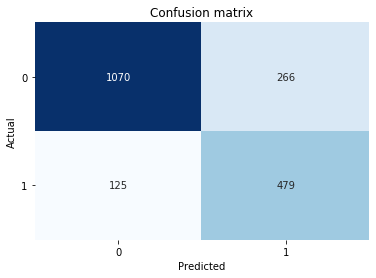

========= Eperiment -  undersampling  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-385


In [70]:
## Losgistic regression model
name="undersampling"
taag ="imbalance"

X_rus,X_test_rus = utills.bow_char(X_rus.flatten(),X_test)
Y_pred_rus = utills.lr(X_rus, X_test_rus, Y_rus)
accuracy, f1_score, recall, precision, auc = utills.result(Y_test,Y_pred_rus)
utills.log_result(Y_test,Y_pred_rus,name,df_name,feature_name,model_name,tag)
final_result.loc[name] = [accuracy, f1_score, recall, precision, auc]

In [75]:
final_result.head()


,Accuracy,F1-score,Recall,Precision,AUC
baseline,0.845876,0.737027,0.693709,0.786116,0.804190
class_weights,0.840722,0.743142,0.740066,0.746244,0.813147
oversampling,0.841753,0.742666,0.733444,0.752122,0.812081
undersampling,0.798454,0.710156,0.793046,0.642953,0.796972


## Hybrid of undersampling and oversampling

In [74]:
rus = RandomUnderSampler(sampling_strategy=0.5,random_state=0) 
ros = RandomOverSampler(sampling_strategy=0.1,random_state=0) 
pipeline = Pipeline(steps=[('o', ros), ('u',rus )])
X_hybrid, y_hybrid = pipeline.fit_resample(X_train.values.reshape(-1,1), Y_train)

TypeError: All intermediate steps should be transformers and implement fit and transform or be the string 'passthrough' 'RandomOverSampler(random_state=0, sampling_strategy=0.1)' (type <class 'imblearn.over_sampling._random_over_sampler.RandomOverSampler'>) doesn't

In [ ]:
## Losgistic regression model
name="hybrid"
tag ="imbalance"

X_hybrid,X_test_hybrid = utills.bow_char(X_hybrid.flatten(),X_test)
Y_pred_hybrid = utills.lr(X_hybrid, X_test_hybrid, Y_hybrid)
accuracy, f1_score, recall, precision, auc = utills.result(Y_test,Y_pred_hybrid)
utills.log_result(Y_test,Y_pred_hybrid,name,df_name,feature_name,model_name,tag)
final_result.loc[name] = [accuracy, f1_score, recall, precision, auc]